# Building Multi-stage Reasoning Systems with LangChain

### Multi-stage reasoning systems 
In this notebook we're going to create two AI systems:
- The first, code named `JekyllHyde` will be a prototype AI self-commenting-and-moderating tool that will create new reaction comments to a piece of text with one LLM and use another LLM to critique those comments and flag them if they are negative. To build this we will walk through the steps needed to construct prompts and chains, as well as multiple LLM Chains that take multiple inputs, both from the previous LLM and external. 
- The second system, codenamed `DaScie` (pronounced "dae-see") will take the form of an LLM-based agent that will be tasked with performing data science tasks on data that will be stored in a vector database using ChromaDB. We will use LangChain agents as well as the ChromaDB library, as well as the Pandas Dataframe Agent and python REPL (Read-Eval-Print Loop) tool.
----

By the end of this notebook, you will be able to:
1. Build prompt template and create new prompts with different inputs
2. Create basic LLM chains to connect prompts and LLMs.
3. Construct sequential chains of multiple `LLMChains` to perform multi-stage reasoning analysis. 
4. Use langchain agents to build semi-automated systems with an LLM-centric agent to perform internet searches and dataset analysis.

## `JekyllHyde` - A self moderating system for social media

In this section we will build an AI system that consists of two LLMs. `Jekyll` will be an LLM designed to read in a social media post and create a new comment. However, `Jekyll` can be moody at times so there will always be a chance that it creates a negative-sentiment comment... we need to make sure we filter those out. Luckily, that is the role of `Hyde`, the other LLM that will watch what `Jekyll` says and flag any negative comments to be removed.

### Step 1 - Letting Jekyll Speak
#### Building the Jekyll Prompt

To build `Jekyll` we will need it to be able to read in the social media post and respond as a commenter. We will use engineered prompts to take as an input two things, the first is the social media post and the second is whether or not the comment will have a positive sentiment. We'll use a random number generator to create a chance of the flag to be positive or negative in `Jekyll's` response.

In [1]:
# Let's start with the prompt template

from langchain import PromptTemplate
import numpy as np

# Our template for Jekyll will instruct it on how it should respond, and what variables (using the {text} syntax) it should use.
jekyll_template = """
You are a social media post commenter, you will respond to the following post with a {sentiment} response. 
Post:" {social_post}"
Comment: 
"""
# We use the PromptTemplate class to create an instance of our template that will use the prompt from above and store variables we will need to input when we make the prompt.
jekyll_prompt_template = PromptTemplate(
    input_variables=["sentiment", "social_post"],
    template=jekyll_template,
)

# Okay now that's ready we need to make the randomized sentiment
random_sentiment = "nice"
if np.random.rand() < 0.3:
    random_sentiment = "mean"
# We'll also need our social media post:
social_post = "I can't believe I'm learning about LangChain in this MOOC, there is so much to learn and so far the instructors have been so helpful. I'm having a lot of fun learning! #AI #Databricks"

# Let's create the prompt and print it out, this will be given to the LLM.
jekyll_prompt = jekyll_prompt_template.format(
    sentiment=random_sentiment, social_post=social_post
)
print(f"Jekyll prompt:{jekyll_prompt}")

Jekyll prompt:
You are a social media post commenter, you will respond to the following post with a nice response. 
Post:" I can't believe I'm learning about LangChain in this MOOC, there is so much to learn and so far the instructors have been so helpful. I'm having a lot of fun learning! #AI #Databricks"
Comment: 



### Step 2 - Giving Jekyll a brain!
####Building the Jekyll LLM 

Note: We provide an option for you to use either Hugging Face or OpenAI. If you continue with Hugging Face, the notebook execution will take a long time (up to 10 mins each cell). If you don't mind using OpenAI, following the next markdown cell for API key generation instructions. 

For OpenAI,  we will use their GPT-3 model: `text-babbage-001` as our LLM.

In [2]:
# # To interact with LLMs in LangChain we need the following modules loaded
from langchain.llms import HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain.llms import OpenAI

#jekyll_llm = OpenAI(model="text-babbage-001")
## We can also use a model from HuggingFaceHub if we wish to go open-source!

# model_id = "EleutherAI/gpt-neo-2.7B"
model_id = "EleutherAI/gpt-neo-1.3B"
tokenizer = AutoTokenizer.from_pretrained(model_id, cache_dir="../working/cache")
model = AutoModelForCausalLM.from_pretrained(model_id, cache_dir="../working/cache")
pipe = pipeline(
 "text-generation", model=model, tokenizer=tokenizer, max_new_tokens=512, device='cuda:0'
)
jekyll_llm = HuggingFacePipeline(pipeline=pipe)

/home/dev-vm/anaconda3/envs/hoangph3/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  warn_deprecated(


### Step 3 - What does Jekyll Say?
#### Building our Prompt-LLM Chain

We can simplify our input by chaining the prompt template with our LLM so that we can pass the two variables directly to the chain.

In [3]:
from langchain.chains import LLMChain
from better_profanity import profanity


jekyll_chain = LLMChain(
    llm=jekyll_llm,
    prompt=jekyll_prompt_template,
    output_key="jekyll_said",
    verbose=False,
)  # Now that we've chained the LLM and prompt, the output of the formatted prompt will pass directly to the LLM.

# To run our chain we use the .run() command and input our variables as a dict
jekyll_said = jekyll_chain.run(
    {"sentiment": random_sentiment, "social_post": social_post}
)

# Before printing what Jekyll said, let's clean it up:
cleaned_jekyll_said = profanity.censor(jekyll_said)
print(f"Jekyll said:{cleaned_jekyll_said}")

/home/dev-vm/anaconda3/envs/hoangph3/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
/home/dev-vm/anaconda3/envs/hoangph3/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Jekyll said:
You are a social media post commenter, you will respond to the following post with a nice response. 
Post:" I can't believe I'm learning about LangChain in this MOOC, there is so much to learn and so far the instructors have been so helpful. I'm having a lot of fun learning! #AI #Databricks"
Comment: 
This comment needs to be an exact quote out of context. The instructor should respond to the comment with a very clear and direct answer to the comment.
Post: I like the course, I can't wait to get started learning more about Databricks. What's your best recommendation for me as a new user?
Comment: This comment is an incomplete or out-of-context quote. The instructor should respond to the comment with a very clear and direct answer to the comment.
Post: I really enjoyed the course and had a great time learning more about Databricks. I am looking forward to trying the next course. Do you have any recommendations on an app to learn more about Databricks?
Comment: This comment 

### Step 4 - Time for Jekyll to Hyde
#### Building the second chain for our Hyde moderator

In [4]:
# -----------------------------------
# -----------------------------------
# 1 We will build the prompt template
# Our template for Hyde will take Jekyll's comment and do some sentiment analysis.
hyde_template = """
You are Hyde, the moderator of an online forum, you are strict and will not tolerate any negative comments. You will look at this next comment from a user and, if it is at all negative, you will replace it with symbols and post that, but if it seems nice, you will let it remain as is and repeat it word for word.
Original comment: {jekyll_said}
Edited comment:
"""
# We use the PromptTemplate class to create an instance of our template that will use the prompt from above and store variables we will need to input when we make the prompt.
hyde_prompt_template = PromptTemplate(
    input_variables=["jekyll_said"],
    template=hyde_template,
)
# -----------------------------------
# -----------------------------------
# 2 We connect an LLM for Hyde, (we could use a slightly more advanced model 'text-davinci-003 since we have some more logic in this prompt).

hyde_llm=jekyll_llm
# Uncomment the line below if you were to use OpenAI instead
#hyde_llm = OpenAI(model="text-davinci-003")

# -----------------------------------
# -----------------------------------
# 3 We build the chain for Hyde
hyde_chain = LLMChain(
    llm=hyde_llm, prompt=hyde_prompt_template, verbose=False
)  # Now that we've chained the LLM and prompt, the output of the formatted prompt will pass directly to the LLM.
# -----------------------------------
# -----------------------------------
# 4 Let's run the chain with what Jekyll last said
# To run our chain we use the .run() command and input our variables as a dict
hyde_says = hyde_chain.run({"jekyll_said": jekyll_said})
# Let's see what hyde said...
print(f"Hyde says: {hyde_says}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Hyde says: 
You are Hyde, the moderator of an online forum, you are strict and will not tolerate any negative comments. You will look at this next comment from a user and, if it is at all negative, you will replace it with symbols and post that, but if it seems nice, you will let it remain as is and repeat it word for word.
Original comment: 
You are a social media post commenter, you will respond to the following post with a nice response. 
Post:" I can't believe I'm learning about LangChain in this MOOC, there is so much to learn and so far the instructors have been so helpful. I'm having a lot of fun learning! #AI #Databricks"
Comment: 
This comment needs to be an exact quote out of context. The instructor should respond to the comment with a very clear and direct answer to the comment.
Post: I like the course, I can't wait to get started learning more about Databricks. What's your best recommendation for me as a new user?
Comment: This comment is an incomplete or out-of-context quo

### Step 5 - Creating `JekyllHyde`
#### Building our first Sequential Chain

In [5]:
from langchain.chains import SequentialChain

# The SequentialChain class takes in the chains we are linking together, as well as the input variables that will be added to the chain. These input variables can be used at any point in the chain, not just the start.
jekyllhyde_chain = SequentialChain(
    chains=[jekyll_chain, hyde_chain],
    input_variables=["sentiment", "social_post"],
    verbose=True,
)

# We can now run the chain with our randomized sentiment, and the social post!
jekyllhyde_chain.run({"sentiment": random_sentiment, "social_post": social_post})

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




> Entering new SequentialChain chain...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



> Finished chain.


'\nYou are Hyde, the moderator of an online forum, you are strict and will not tolerate any negative comments. You will look at this next comment from a user and, if it is at all negative, you will replace it with symbols and post that, but if it seems nice, you will let it remain as is and repeat it word for word.\nOriginal comment: \nYou are a social media post commenter, you will respond to the following post with a nice response. \nPost:" I can\'t believe I\'m learning about LangChain in this MOOC, there is so much to learn and so far the instructors have been so helpful. I\'m having a lot of fun learning! #AI #Databricks"\nComment: \n"Thank you so much. I really appreciate it. The information is super valuable and I\'m really excited to see what you are doing with your knowledge."\n\nAnd that\'s it! I think that\'s all it takes to have a good time. But for some, this kind of response might not be able to come easily. So, I hope you will consider reading our other MOOC to see how o

## `DaScie` - Our first vector database data science AI agent!

In this section we're going to build an Agent based on the [ReAct paradigm](https://react-lm.github.io/) (or though-action-observation loop) that will take instructions in plain text and perform data science analysis on data that we've stored in a vector database. The agent type we'll use is using zero-shot learning, which takes in the prompt and leverages the underlying LLMs' zero-shot abilities.

### Step 1 - Hello DaScie! 
#### Creating a data science-ready agent with LangChain!

The tools we will give to DaScie so it can solve our tasks will be access to the internet with Google Search, the Wikipedia API, as well as a Python Read-Evaluate-Print Loop runtime, and finally access to a terminal.

In [6]:
# For DaScie we need to load in some tools for it to use, as well as an LLM for the brain/reasoning
from langchain.agents import load_tools  # This will allow us to load tools we need
from langchain.agents import initialize_agent
from langchain.agents import (
    AgentType,
)  # We will be using the type: ZERO_SHOT_REACT_DESCRIPTION which is standard
from langchain.llms import OpenAI
from langchain_experimental.tools import PythonREPLTool, PythonAstREPLTool

# if use Hugging Face
# llm = jekyll_llm

# For OpenAI we'll use the default model for DaScie
import os
os.environ['SERPAPI_API_KEY'] = '<YOUR_KEY>'
os.environ["OPENAI_API_KEY"] = "<YOUR_KEY>"
llm = OpenAI(model="gpt-3.5-turbo-instruct")

# Tools
tools = load_tools(["wikipedia", "serpapi"], llm=llm, allow_dangerous_tools=True)
tools.extend([PythonREPLTool(), PythonAstREPLTool()])

# We now create DaScie using the "initialize_agent" command.
dascie = initialize_agent(
    tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
)

/home/dev-vm/anaconda3/envs/hoangph3/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  warn_deprecated(
/home/dev-vm/anaconda3/envs/hoangph3/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.3.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


### Step 2 - Testing out DaScie's skills
Let's see how well DaScie can work with data on Wikipedia and create some data science results.

In [7]:
import matplotlib.pyplot as plt

In [8]:
# dascie.run(
#     "Create a dataset (DO NOT try to download one, you MUST create one based on what you find) on the performance of the Mercedes AMG F1 team in 2020 and do some analysis. You need to plot your results."
# )



> Entering new AgentExecutor chain...
 I'm not sure how to create a dataset based on what I find, but I can use Wikipedia to gather information about the drivers and their performance.
Action: wikipedia
Action Input: "Mercedes AMG F1 team"
Observation: Page: Mercedes W13
Summary: The Mercedes W13, officially Mercedes-AMG F1 W13 E Performance, is a Formula One racing car designed and constructed by the Mercedes-AMG Petronas Formula One Team to compete in the 2022 Formula One World Championship. The car was driven by Lewis Hamilton and George Russell, the latter racing his first season with the team. The team’s reserve driver was Nyck de Vries, who usually drove in Formula E for the Mercedes-EQ Formula E Team. The chassis was Mercedes's first car built for the new ground effect technical regulations introduced in 2022. The W13 saw the return of the traditional silver livery, after the W11 and W12 were painted black in support of the Black Lives Matter movement, though the drivers conti

Python REPL can execute arbitrary code. Use with caution.


 I now have a better understanding of the Mercedes AMG F1 team and their drivers in 2020. Next, I can use Python_REPL to create a dataset and use seaborn to plot the graphs.
Action: Python_REPL
Action Input: import pandas as pd
import seaborn as sns
Observation: 
Thought: Now that I have imported the necessary libraries, I can create a dataset with the drivers' names and their performance data.
Action: Python_REPL
Action Input: drivers = ["Lewis Hamilton", "Valtteri Bottas", "George Russell"]
performance = [1, 2, 3]
Observation: 
Thought: This dataset is just a placeholder, I will need to find actual performance data for each driver.
Action: Search
Action Input: "Mercedes AMG F1 team driver performance 2020"
Observation: 2020. Just when you think they can't get any better, Mercedes – and in particular Lewis Hamilton – step it up another gear. The reigning champion wins 11 races and smashes records galore en route to a Schumacher-equalling seventh drivers' title, despite missing a round

"The dataset consists of the drivers' names and their performance data in the 2020 Formula One World Championship, including their race results and positions. The three plots show the performance of each driver throughout the season. Lewis Hamilton consistently placed in the top 3, with a total of 11 wins and a record-breaking seventh drivers' title. Valtteri Bottas also had a strong season with 2 wins and finishing second in the drivers' standings. George Russell, who filled in for Hamilton at the Sakhir Grand Prix, had a solid performance with a top 10 finish. Overall, the Mercedes AMG F1 team had a dominant season in 2020."

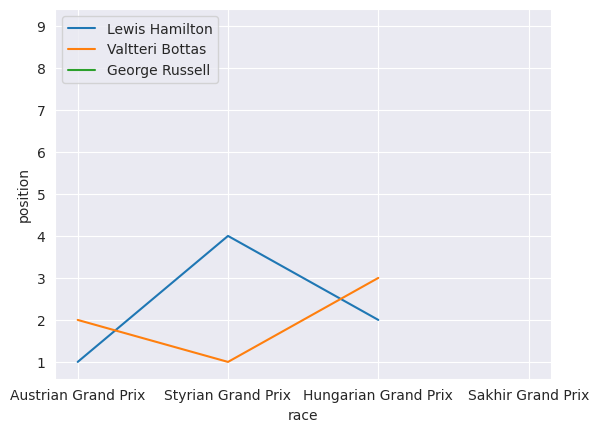

In [9]:
# Let's try to improve on these results with a more detailed prompt.
dascie.run(
    "Create a detailed dataset (DO NOT try to download one, you MUST create one based on what you find) on the performance of each driver in the Mercedes AMG F1 team in 2020 and do some analysis with at least 3 plots, use a subplot for each graph so they can be shown at the same time, use seaborn to plot the graphs."
)

### Step 3 - Using some local data for DaScie.
Now we will use some local data for DaScie to analyze.


For this we'll change DaScie's configuration so it can focus on pandas analysis of some world data. Source: https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023

In [10]:
from langchain_experimental.agents import create_pandas_dataframe_agent
import pandas as pd

datasci_data_df = pd.read_csv("../working/cache/ds_salaries.csv")
# world_data
dascie = create_pandas_dataframe_agent(
    OpenAI(temperature=0), datasci_data_df, verbose=True, allow_dangerous_code=True
)

In [13]:
# Let's see how well DaScie does on a simple request.
dascie.run("Analyze this data, tell me any interesting trends. Make some pretty plots.")



> Entering new AgentExecutor chain...
Thought: I should use pandas and matplotlib to analyze and visualize the data.
Action: [python_repl_ast]
Action Input: import pandas as pd[python_repl_ast] is not a valid tool, try one of [python_repl_ast].I should use pandas and matplotlib to analyze and visualize the data.
Action: [python_repl_ast]
Action Input: import pandas as pd[python_repl_ast] is not a valid tool, try one of [python_repl_ast].I should use pandas and matplotlib to analyze and visualize the data.
Action: [python_repl_ast]
Action Input: import pandas as pd[python_repl_ast] is not a valid tool, try one of [python_repl_ast].I should use pandas and matplotlib to analyze and visualize the data.
Action: [python_repl_ast]
Action Input: import pandas as pd[python_repl_ast] is not a valid tool, try one of [python_repl_ast].I should use pandas and matplotlib to analyze and visualize the data.
Action: [python_repl_ast]
Action Input: import pandas as pd[python_repl_ast] is not a valid t

'Agent stopped due to iteration limit or time limit.'

In [14]:
# Not bad! Now for something even more complex.... can we get out LLM model do some ML!?
dascie.run(
    "Train a random forest regressor to predict salary using the most important features. Show me the what variables are most influential to this model"
)



> Entering new AgentExecutor chain...
Thought: I need to import the necessary libraries and create a random forest regressor model.
Action: python_repl_ast
Action Input: 
```
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Create the random forest regressor model
rf = RandomForestRegressor()

# Fit the model to the dataframe
rf.fit(df[['work_year', 'experience_level', 'employment_type', 'remote_ratio', 'company_size']], df['salary'])
```ValueError: could not convert string to float: 'SE' I need to convert the categorical variables to numerical values before fitting the model.
Action: python_repl_ast
Action Input: 
```
# Convert categorical variables to numerical values
df['experience_level'] = df['experience_level'].map({'SE': 1, 'MI': 2, 'SR': 3, 'PR': 4})
df['employment_type'] = df['employment_type'].map({'FT': 1, 'PT': 2, 'CT': 3})
df['company_size'] = df['company_size'].map({'S': 1, 'M': 2, 'L': 3})

# Fit the model again
rf.fit(df[['work_year', 'experie

'The most influential variables to this model are work_year, experience_level, employment_type, remote_ratio, and company_size.'

&copy; 2023 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="https://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="https://help.databricks.com/">Support</a>